In [1]:
import sys
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# add src/model and src/hardware to path
model_dir = Path("..").resolve()
hardware_dir = Path("..", "..", "hardware").resolve()

for d in (model_dir, hardware_dir):
    if str(d) not in sys.path:
        sys.path.append(str(d))

from bubble_cv_model import BubbleCVModel
from bubble_cnn_model import BubbleCNNModel


In [2]:
from pathlib import Path

VIDEO_PATH = Path("../../..") / "data" / "raw" / "bubbles_synth_02.mp4"
CKPT_PATH  = Path("../../..") / "data" / "cnn" / "small_unet_bubbles.pt"

print("VIDEO_PATH exists:", VIDEO_PATH.exists(), VIDEO_PATH)
print("CKPT_PATH exists:", CKPT_PATH.exists(), CKPT_PATH)


VIDEO_PATH exists: True ..\..\..\data\raw\bubbles_synth_02.mp4
CKPT_PATH exists: True ..\..\..\data\cnn\small_unet_bubbles.pt


In [3]:
cv_model  = BubbleCVModel(min_diam_px=5)
cnn_model = BubbleCNNModel(ckpt_path=CKPT_PATH, min_diam_px=5)


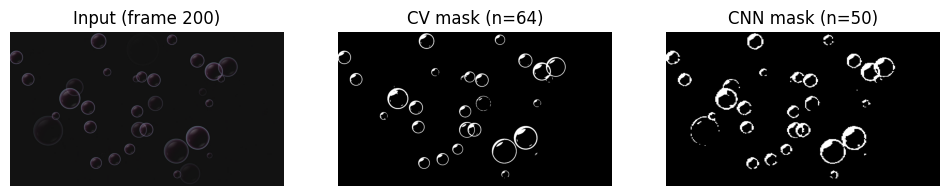

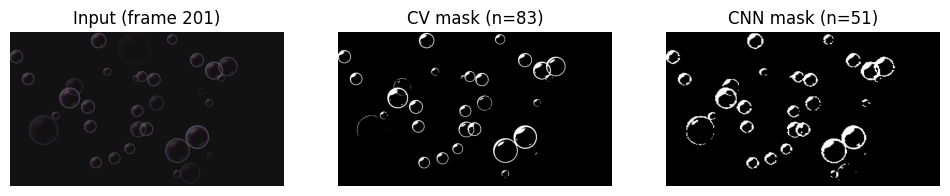

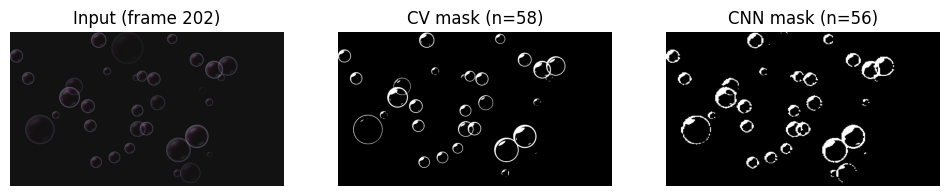

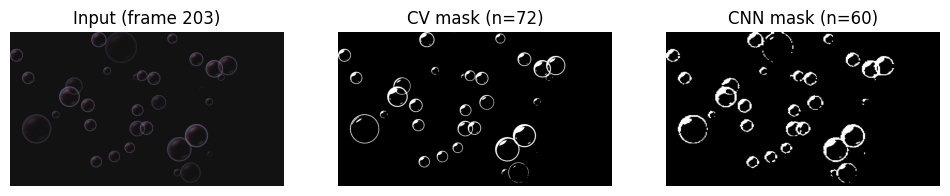

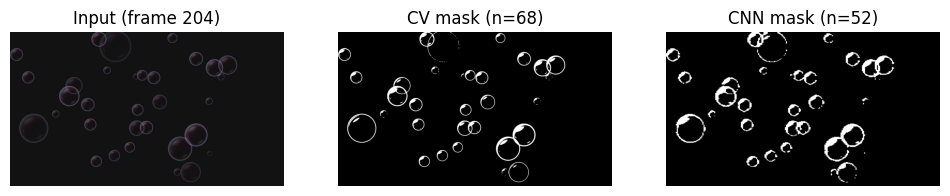

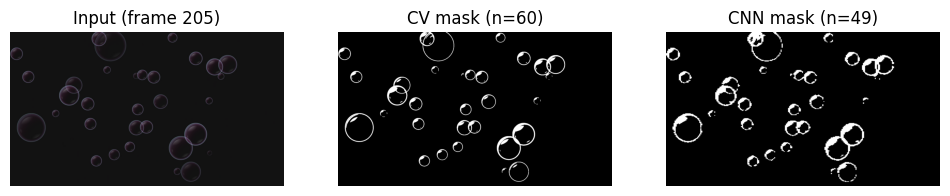

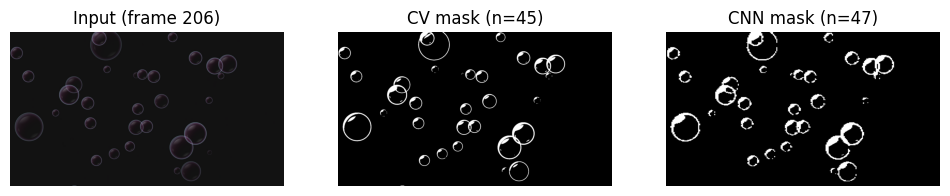

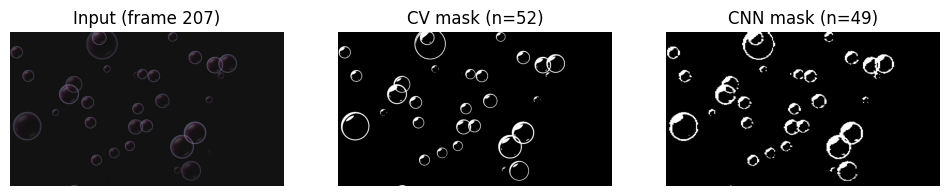

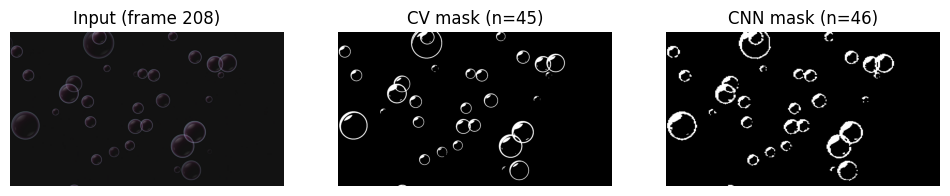

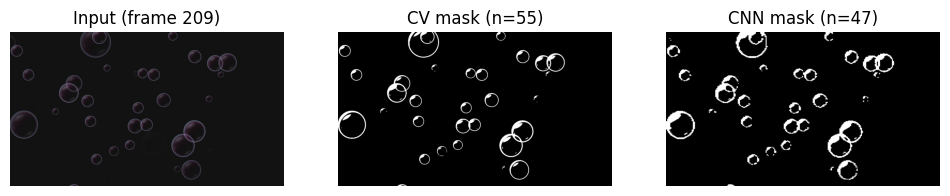

In [5]:
cap = cv2.VideoCapture(str(VIDEO_PATH))

start_frame = 200        # pick whatever offset you want
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

frames_shown = 0

while frames_shown < 10:  # show 10 frames starting at ~frame 200
    ret, frame = cap.read()
    if not ret:
        break

    mask_cv,  bubbles_cv  = cv_model.predict(frame)
    mask_cnn, bubbles_cnn = cnn_model.predict(frame)

    vis = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(vis)
    plt.title(f"Input (frame {start_frame + frames_shown})")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(mask_cv, cmap="gray")
    plt.title(f"CV mask (n={len(bubbles_cv)})")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(mask_cnn, cmap="gray")
    plt.title(f"CNN mask (n={len(bubbles_cnn)})")
    plt.axis("off")

    plt.show()

    frames_shown += 1

cap.release()


In [3]:
output_path = Path("../../..") / "data" / "processed" / "bubbles_synth_annotated.mp4"

cap = cv2.VideoCapture(str(VIDEO_PATH))
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(str(output_path), fourcc, fps, (w, h))

model = BubbleCVModel(min_diam_px=5)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    mask, bubbles = model.predict(frame)

    vis = frame.copy()
    for b in bubbles:
        x, y, w, h = b["x"], b["y"], b["w"], b["h"]
        cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 255, 0), 1)

    writer.write(vis)

cap.release()
writer.release()
output_path


WindowsPath('../../../data/processed/bubbles_synth_annotated.mp4')

In [3]:
# run in a new script or notebook cell
from pathlib import Path
import cv2
import numpy as np
from bubble_cv_model import BubbleCVModel

VIDEO_PATH = Path("../../..") / "data" / "raw" / "bubbles_synth_01.mp4"
out_img_dir = Path("../../..") / "data" / "cnn" / "images"
out_msk_dir = Path("../../..") / "data" / "cnn" / "masks"
out_img_dir.mkdir(parents=True, exist_ok=True)
out_msk_dir.mkdir(parents=True, exist_ok=True)

cap = cv2.VideoCapture(str(VIDEO_PATH))
model = BubbleCVModel(min_diam_px=5)

frame_idx = 0
stride = 3  # take every 3rd frame to avoid too many near-duplicates

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % stride == 0:
        mask, _ = model.predict(frame)

        # resize down for easier training
        frame_small = cv2.resize(frame, (256, 256))
        mask_small = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        cv2.imwrite(str(out_img_dir / f"frame_{frame_idx:05d}.png"), frame_small)
        cv2.imwrite(str(out_msk_dir / f"frame_{frame_idx:05d}.png"), mask_small)

    frame_idx += 1

cap.release()
